In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import fasttreeshap
import shap
import pickle
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors
import timeit
from joblib import Parallel, delayed
shap.initjs()

In [3]:
#import dataset
data = pd.read_csv("../data_sets/scaled_annual_data_JFE.csv")
y = data.iloc[:,2]
X = data.iloc[:,3:]
Dates = data.iloc[:,1]

In [4]:
# train random forest model with same specification as in R
model = RandomForestRegressor(n_estimators = 100, 
                              max_features = 17,
                              random_state = 1011)
model.fit(X, y)

RandomForestRegressor(max_features=17, random_state=1011)

In [5]:
#Build explainer
explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)

In [6]:
""" #Get SHAP interaction values in parallel mode
start = timeit.default_timer()

def get_shap_interactions(explainer,X,i):
    shap_interaction = explainer(X.iloc[i,:],interactions = True).values
    return shap_interaction

shap_interaction = Parallel(n_jobs=-1)(delayed(get_shap_interactions)(explainer,X,i) for i in range(np.shape(X)[0]))

#save shap interactions
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# sample usage
save_object(shap_interaction, 'shap_interactions_scaled_vars_RF.pkl')

# Get SHAP values of variables' main effect
shap_values = explainer(X,interactions = False).values

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        
save_object(shap_values, 'shap_values_scaled_vars_RF.pkl')

stop = timeit.default_timer()
print('Time: ', stop - start) """

" #Get SHAP interaction values in parallel mode\nstart = timeit.default_timer()\n\ndef get_shap_interactions(explainer,X,i):\n    shap_interaction = explainer(X.iloc[i,:],interactions = True).values\n    return shap_interaction\n\nshap_interaction = Parallel(n_jobs=-1)(delayed(get_shap_interactions)(explainer,X,i) for i in range(np.shape(X)[0]))\n\n#save shap interactions\nimport pickle\n\ndef save_object(obj, filename):\n    with open(filename, 'wb') as outp:  # Overwrites any existing file.\n        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)\n\n# sample usage\nsave_object(shap_interaction, 'shap_interactions_scaled_vars_RF.pkl')\n\n# Get SHAP values of variables' main effect\nshap_values = explainer(X,interactions = False).values\n\ndef save_object(obj, filename):\n    with open(filename, 'wb') as outp:  # Overwrites any existing file.\n        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)\n        \nsave_object(shap_values, 'shap_values_scaled_vars_RF.pkl')\n\nstop = timeit.d

#### Variable importance

In [7]:
# load saves shapley values of variables' main effect
with open('shap_values_scaled_vars_RF.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    shap_values = pickle.load(f)    

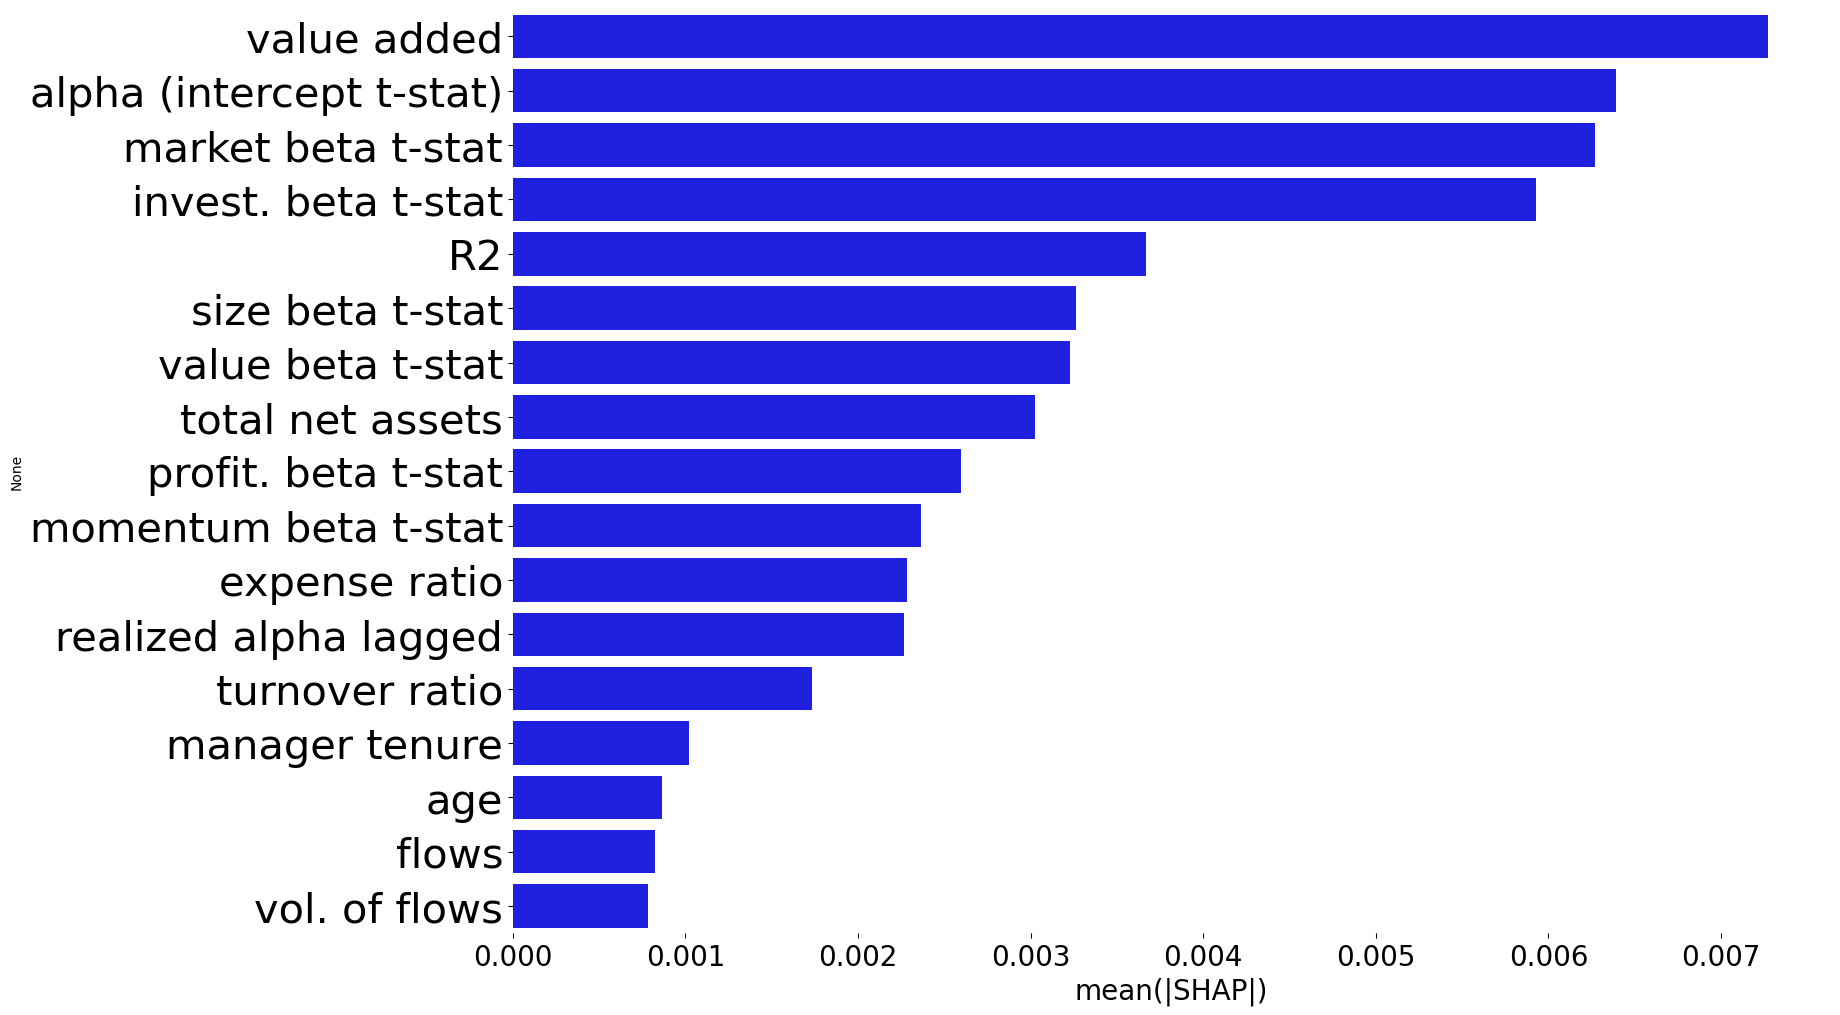

In [ ]:
# Dataframe with average absolute SHAP values
abs_shap_values = np.abs(shap_values)
abs_shap_values = pd.DataFrame(abs_shap_values,columns=X.columns)
abs_shap_values_mean=abs_shap_values.mean(0)
abs_shap_values_mean = abs_shap_values_mean.sort_values(ascending=False)

# Set seaborn style
sns.set_theme(style="whitegrid", context="talk")

# Prepare data for plotting
df = abs_shap_values_mean.rename_axis('feature').reset_index(name='importance')

# Create color gradient
cmap = plt.cm.viridis
norm = plt.Normalize(df['importance'].min(), df['importance'].max())
colors = cmap(norm(df['importance'].values))

# Create plot
fig, ax = plt.subplots(figsize=(14, 10))
ax.barh(df['feature'], df['importance'], color=colors)
ax.invert_yaxis()

# Customize labels and title
ax.set_xlabel('mean(|SHAP|)', fontsize=18)
ax.set_ylabel('Feature', fontsize=18)
ax.set_title('Variable Importance (RF) — mean(|SHAP|)', fontsize=20)

# Customize grid and spines
ax.grid(axis='x', linestyle='--', alpha=0.35)
sns.despine(left=True, bottom=True)

# Add value labels
for i, v in enumerate(df['importance']):
    ax.text(v + df['importance'].max()*0.01, i, f'{v:.3f}', va='center', fontsize=12, color='#333')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Importance', fontsize=14)

plt.tight_layout()
plt.savefig("variable_importance_SHAP_RF_styled.pdf", format="pdf", bbox_inches="tight")

#### Interacion importance

In [9]:
#load shap interactions

with open('shap_interactions_scaled_vars_RF.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    shap_interaction = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'shap_interactions_scaled_vars_RF.pkl'

In [ ]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

In [ ]:
#create barplot of interaction values

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of SHAP interaction matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_interactions(df):
    au_corr = df.unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

interaction_bar_plot = get_interactions(df)

interaction_bar_plot = interaction_bar_plot[0:29].sort_values(ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize =(17,12))
plt.yticks(fontsize=25)
plt.xticks(fontsize=20)
plt.xlabel('mean(|SHAP|)',fontsize=20)
norm = TwoSlopeNorm(vmin=-1, vcenter =0, vmax=1)
colors = [plt.cm.RdYlGn(norm(c)) for c in interaction_bar_plot.values]
ax.set_facecolor('white')
interaction_bar_plot.plot.barh(color="blue",width = 0.9)
plt.savefig("interaction_importance_SHAP_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
df_shap_values = pd.DataFrame(shap_values,columns=X.columns)
df_shap_values.to_csv("shap_values_RF.csv", index=False)

In [ ]:
#Display summary plot for shap values of variable main effects
fasttreeshap.summary_plot(shap_values, X,show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.gca().set_facecolor('white')
plt.savefig("swarm_plot_SHAP_RF.pdf", format="pdf", bbox_inches="tight")

# Bar plot for variable importance with seaborn

In [ ]:
#Display summary plot for shap values of variable interactions
shap.summary_plot(np.asarray(shap_interaction), X)

In [ ]:
# value added-R2 dependence plot
shap.dependence_plot(
    ("value added", "R2"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# value added-market beta dependence plot
shap.dependence_plot(
    ("value added", "market beta t-stat"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# value added-investment beta dependence plot
shap.dependence_plot(
    ("value added","invest. beta t-stat"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# alpha tstat-investment beta dependence plot
shap.dependence_plot(
    ("alpha (intercept t-stat)","invest. beta t-stat"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# R2-alpha (t-stat) dependence plot
shap.dependence_plot(
    ("alpha (intercept t-stat)","R2"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# market beta t-stat-alpha (t-stat) depenence plot
shap.dependence_plot(
    ("alpha (intercept t-stat)","market beta t-stat"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# value added-investment beta dependence plot
shap.dependence_plot(
    ("invest. beta t-stat","value added"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# market beta t-stat-R2 dependence plot
shap.dependence_plot(
    ("R2","market beta t-stat"),
    np.asarray(shap_interaction), X,
    display_features=X)

In [ ]:
# value added dependence plot
shap.dependence_plot("value added",shap_values, X, interaction_index=None)

In [ ]:
# R2 dependence plot
shap.dependence_plot("R2",shap_values, X, interaction_index=None)

In [ ]:
# market beta t-stat dependence plot
shap.dependence_plot("market beta t-stat",shap_values, X, interaction_index=None)

In [ ]:
# investment beta t-stat dependence plot
shap.dependence_plot("invest. beta t-stat",shap_values, X, interaction_index=None)

In [ ]:
# alpha (intercept t-stat) dependence plot
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index=None)

In [ ]:
# Automatically save the top-20 interactilns
interaction_bar_plot = interaction_bar_plot.sort_values(ascending=False)

for i in range(19):
    shap.dependence_plot(
        (interaction_bar_plot.index[i][0], interaction_bar_plot.index[i][1]),
        np.asarray(shap_interaction), X,
        display_features=X,show=False)
    plt.savefig('shap_interaction_'+ interaction_bar_plot.index[i][0] + '_' + interaction_bar_plot.index[i][1]   +'_RF.png')

# Dependence Plots with interaction

In [ ]:
# Automatically save the top-20 dependence plots with interactions
interaction_bar_plot = interaction_bar_plot.sort_values(ascending=False)

for i in range(19):
    # version 1
    shap.dependence_plot(interaction_bar_plot.index[i][0],shap_values,X,interaction_index=interaction_bar_plot.index[i][1],show=False)
    plt.savefig('shap_dependence_plot_'+ interaction_bar_plot.index[i][0] + '_' + interaction_bar_plot.index[i][1]   +'_RF.png')
    # version 2
    shap.dependence_plot(interaction_bar_plot.index[i][1],shap_values,X,interaction_index=interaction_bar_plot.index[i][0],show=False)
    plt.savefig('shap_dependence_plot_'+ interaction_bar_plot.index[i][1] + '_' + interaction_bar_plot.index[i][0]   +'_RF.png')
    

In [ ]:
# alpha t-stat vs market beta t-stat
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="market beta t-stat")

In [ ]:
# market beta t-stat
shap.dependence_plot("market beta t-stat",shap_values, X, interaction_index=None,show=False)
plt.savefig("market_beta_tstat_dependence_plot_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# market beta t-stat dependence plot IN DECILES
X_new=X[['R2','alpha (intercept t-stat)','market beta t-stat']]
X_new = X_new.assign(deciles = pd.qcut(X_new['market beta t-stat'], 10, labels = False, duplicates='drop'))
df_shap_values = pd.DataFrame(shap_values,columns=X.columns)['market beta t-stat']
new_df = X_new
new_df =  new_df.assign(shap_values=df_shap_values)

new_df['deciles'] = new_df['deciles'].map(lambda x: x+1)
plt.figure(figsize =(8,6))
sns.lineplot(x='deciles', y='shap_values', data=new_df, palette='Paired',linewidth=3,marker="X",ci=None)
plt.xlabel('Deciles of market beta t-stat')
plt.ylabel('SHAP values')
plt.title('market beta t-stat')
plt.savefig("market_beta_tstat_dependence_plot_deciles_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# alpha t-stat vs value added
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="value added")

In [ ]:
# total net assets vs value added
shap.dependence_plot("value added",shap_values, X, interaction_index=None)

In [ ]:
# value added dependence plot IN DECILES
X_new=X[['R2','alpha (intercept t-stat)','market beta t-stat','value added']]
X_new = X_new.assign(deciles = pd.qcut(X_new['value added'], 10, labels = False, duplicates='drop'))
df_shap_values = pd.DataFrame(shap_values,columns=X.columns)['value added']
new_df = X_new
new_df =  new_df.assign(shap_values=df_shap_values)

new_df['deciles'] = new_df['deciles'].map(lambda x: x+1)
plt.figure(figsize =(8,6))
sns.lineplot(x='deciles', y='shap_values', data=new_df, palette='Paired',linewidth=3,marker="X",ci=None)
plt.xlabel('Deciles of value added')
plt.ylabel('SHAP values')
plt.title('value added')
plt.savefig("value_added_dependence_plot_deciles_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# market beta t-stat vs invest. beta t stat
shap.dependence_plot("invest. beta t-stat",shap_values, X, interaction_index="market beta t-stat")

In [ ]:
# alpha t-stat vs value added
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="invest. beta t-stat")

In [ ]:
# value added vs invest. beta t stat
shap.dependence_plot("value added",shap_values, X, interaction_index="invest. beta t-stat")

In [ ]:
# alpha t-stat vs R2
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="R2")

In [ ]:
# value added vs size beta t stat
shap.dependence_plot("value added",shap_values, X, interaction_index="size beta t-stat")

In [ ]:
# value added vs market beta t stat
shap.dependence_plot("value added",shap_values, X, interaction_index="market beta t-stat")

In [ ]:
# alpha t-stat vs value beta t-stat
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index=None,show=False)
plt.savefig("alpha_intercept_tstat_dependence_plot_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# ALPHA t-stat dependence plot IN DECILES
X_new=X[['R2','alpha (intercept t-stat)','market beta t-stat']]
X_new = X_new.assign(deciles = pd.qcut(X_new['alpha (intercept t-stat)'], 10, labels = False, duplicates='drop'))
df_shap_values = pd.DataFrame(shap_values,columns=X.columns)['alpha (intercept t-stat)']
new_df = X_new
new_df =  new_df.assign(shap_values=df_shap_values)

new_df['deciles'] = new_df['deciles'].map(lambda x: x+1)
plt.figure(figsize =(8,6))
sns.lineplot(x='deciles', y='shap_values', data=new_df, palette='Paired',linewidth=3,marker="X",ci=None)
plt.xlabel('Deciles of alpha (intercept t-stat)')
plt.ylabel('SHAP values')
plt.title('alpha (intercept t-stat)')
plt.savefig("alpha_tstat_dependence_plot_deciles_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# alpha t-stat vs profit. beta t-stat
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="profit. beta t-stat")

In [ ]:
# alpha t-stat vs realized alpha lagged
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="realized alpha lagged")

In [ ]:
# alpha t-stat vs size beta t-stat
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="size beta t-stat")

In [ ]:
# alpha t-stat vs total net assets
shap.dependence_plot("alpha (intercept t-stat)",shap_values, X, interaction_index="total net assets")

In [ ]:
# R2 vs invest. beta t stat
shap.dependence_plot("invest. beta t-stat",shap_values, X, interaction_index="R2")

In [ ]:
# market beta t-stat vs value beta t stat
shap.dependence_plot("value beta t-stat",shap_values, X, interaction_index="market beta t-stat")

In [ ]:
# value added vs value beta t stat
shap.dependence_plot("value beta t-stat",shap_values, X, interaction_index="value added")

In [ ]:
# R2
shap.dependence_plot("R2",shap_values, X, interaction_index=None,show=False)
plt.savefig("R2_dependence_plot_RF.pdf", format="pdf", bbox_inches="tight")

In [ ]:
# R2 dependence plot IN DECILES
X_new=X[['R2','alpha (intercept t-stat)','market beta t-stat']]
X_new = X_new.assign(deciles = pd.qcut(X_new['R2'], 10, labels = False, duplicates='drop'))
df_shap_values = pd.DataFrame(shap_values,columns=X.columns)['R2']
new_df = X_new
new_df =  new_df.assign(shap_values=df_shap_values)

new_df['deciles'] = new_df['deciles'].map(lambda x: x+1)
plt.figure(figsize =(8,6))
sns.lineplot(x='deciles', y='shap_values', data=new_df, palette='Paired',linewidth=3,marker="X",ci=None)
plt.xlabel('Deciles of R2')
plt.ylabel('SHAP values')
plt.title('R2')
plt.savefig("R2_dependence_plot_deciles_RF.pdf", format="pdf", bbox_inches="tight")

# Dependence plots with selected performance and selectivity measures


In [ ]:
performance_vars = ["alpha (intercept t-stat)", "value added", "realized alpha lagged"]
selectivity_vars = ["R2","market beta t-stat","value beta t-stat","size beta t-stat","profit. beta t-stat","momentum beta t-stat"]

for i in range(len(performance_vars)):
    for j in range(len(selectivity_vars)):
        shap.dependence_plot(performance_vars[i],shap_values,X,interaction_index=selectivity_vars[j],show=False)
        plt.savefig('shap_dependence_plot_'+ performance_vars[i] + '_' + selectivity_vars[j]   +'_RF.png')

# Value added dependence plots with winsorization

In [ ]:
performance_vars = ["value added"]
selectivity_vars = ["R2","market beta t-stat","value beta t-stat","size beta t-stat","profit. beta t-stat","momentum beta t-stat"]

for i in range(len(performance_vars)):
    for j in range(len(selectivity_vars)):
        shap.dependence_plot(performance_vars[i],shap_values,X,interaction_index=selectivity_vars[j],show=False,xmin=-3,xmax=3)
        plt.savefig('shap_dependence_plot_'+ 'winsozized_value_added' + '_' + selectivity_vars[j]   +'_RF.png')
   

# Dependence plots after preserving observations in top and bottom deciles

In [ ]:
performance_vars = ["alpha (intercept t-stat)", "value added", "realized alpha lagged"]
selectivity_vars = ["R2","market beta t-stat","value beta t-stat","size beta t-stat","profit. beta t-stat","momentum beta t-stat"]

for i in range(len(selectivity_vars)):
    for j in range(len(performance_vars)):
        # calculate the decile boundaries for the column you want to filter by
        column = selectivity_vars[i]
        decile_boundaries = pd.qcut(X[column], 10, labels = False)        
        # create a mask for the top decile
        top_decile_mask = X[column] >= decile_boundaries[8]
        # create a mask for the bottom decile
        bottom_decile_mask = X[column] <= decile_boundaries[1]
        # filter the data set by the top decile
        top_decile_X = X[top_decile_mask]
        # filter the data set by the bottom decile
        bottom_decile_X = X[bottom_decile_mask]
        X_filtered = top_decile_X.append(bottom_decile_X)
        # recalculate Shap values
        shap_values_filtered = explainer(X_filtered,interactions = False).values
        # dependence plot        
        shap.dependence_plot(performance_vars[j],shap_values_filtered,X_filtered,interaction_index=selectivity_vars[i],show=False)
        plt.savefig('shap_dependence_plot_top_bottom_deciles_'+ performance_vars[j] + '_' + selectivity_vars[i]   +'_RF.png')
      




# Generate dependence plots for deciles of selected interactions

In [ ]:
performance_vars = ["alpha (intercept t-stat)", "value added", "realized alpha lagged"]
selectivity_vars = ["R2","market beta t-stat","value beta t-stat","size beta t-stat","profit. beta t-stat","momentum beta t-stat"]

for i in range(len(performance_vars)):
    for j in range(len(selectivity_vars)):
        plt.close()
        X_new = X[[performance_vars[i],selectivity_vars[j]]]
        X_new = X_new.assign(deciles_perf = pd.qcut(X_new[performance_vars[i]], 10, labels = False, duplicates='drop'))
        X_new = X_new.assign(deciles_selec = pd.qcut(X_new[selectivity_vars[j]], 10, labels = False, duplicates='drop'))
        df_shap_values = pd.DataFrame(shap_values,columns=X.columns)[performance_vars[i]]
        new_df = X_new
        new_df =  new_df.assign(shap_values=df_shap_values)
        new_df['deciles_perf'] = new_df['deciles_perf'].map(lambda x: x+1)
        new_df['deciles_selec'] = new_df['deciles_selec'].map(lambda x: x+1)
        #plt.figure(figsize =(17,12))
        sns.lineplot(x='deciles_perf', y='shap_values', hue='deciles_selec', data=new_df, palette='Paired',linewidth=3,marker="X",ci=None)
        plt.xlabel('Deciles of ' + performance_vars[i])
        plt.ylabel('SHAP values')
        plt.title(performance_vars[i])
        plt.legend(title='Deciles of\n' + selectivity_vars[j])     
        plt.savefig('shap_percentile_plot_'+ performance_vars[i] + '_' + selectivity_vars[j]   +'_RF.pdf', format="pdf", bbox_inches="tight")
        plt.close()
        lst = [X_new, new_df, df_shap_values, plt]
        del lst

# Save Shapley values to csv

In [ ]:
shapley_values_df = pd.DataFrame(shap_values,columns=X.columns)
shapley_values_df.to_csv("shap_values_RF.csv",index=False)

# Plot time evolution of annual Shapley values

In [ ]:
Dates = pd.Series(Dates, name='Dates')
df_shapley_annual = pd.concat([Dates, pd.DataFrame(shap_values,columns=X.columns)],axis=1)
df_shapley_annual['Dates'] = pd.to_datetime(df_shapley_annual['Dates'], format='%Y%m')

In [ ]:
abs_mean_df = df_shapley_annual.groupby(df_shapley_annual['Dates'].dt.year).apply(lambda x: x.iloc[:,1:].abs().mean()).reset_index()
abs_mean_df.set_index('Dates', inplace=True)

In [ ]:
# normalize the average of the absolute value of each numeric column per year
abs_mean_norm_df = (abs_mean_df - abs_mean_df.min(axis=1).values.reshape(-1,1)) / (abs_mean_df.max(axis=1) - abs_mean_df.min(axis=1)).values.reshape(-1,1)
abs_mean_norm_df = abs_mean_norm_df * 100

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(17, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < abs_mean_norm_df.shape[1]:
        abs_mean_norm_df.iloc[:, i].plot(ax=ax, ylim=(-5, 105), color="black")
        ax.set_title(abs_mean_norm_df.columns[i])
        ax.set_xlabel("")
    else:
        fig.delaxes(ax)

for ax in axes:
    ax.set_facecolor('white')      
plt.tight_layout()
    
plt.savefig("annual_SHAP_RF_normalized.pdf", format="pdf", bbox_inches="tight")